In [1]:
import pandas as pd
import numpy as np
from scipy.signal import correlate2d
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


First let's load our data and convert everything to microns.

In [2]:
def load_and_convert_data(file_path):
    df = pd.read_csv(file_path, sep=',', skiprows=2)
    
    # Convert position and velocity to microns and microns/second
    df['x [um]'] = df['x [m]'] * 1E6
    df['y [um]'] = df['y [m]'] * 1E6
    df['u [um/s]'] = df['u [m/s]'] * 1E6
    df['v [um/s]'] = df['v [m/s]'] * 1E6
    
    # Drop the original columns and retain only the converted ones
    df = df[['x [um]', 'y [um]', 'u [um/s]', 'v [um/s]']]
    
    return df

# Load the data using the updated function
data_0001 = load_and_convert_data("C:/Users/dalar/OneDrive/Desktop/current_experiment/100223-kbio-500_250_125nM/pos1-250nM/piv-pos1-250nM/txt-250nM-complete_movie/PIVlab_0001.txt")



Let's write down two functions to obtain autocorrelation - one for velocity magnitude (don't care about directionality) and other that computes autocorrelation of u and v components separately.

In [6]:
def compute_velocity_autocorrelation(data):
    """
    Compute the velocity autocorrelation from the velocity field.
    """
    u = data.pivot(index='y [um]', columns='x [um]', values='u [um/s]').values
    v = data.pivot(index='y [um]', columns='x [um]', values='v [um/s]').values

    # Handle NaN values: replacing them with zero
    u[np.isnan(u)] = 0
    v[np.isnan(v)] = 0

    # Normalizing the velocities
    u = u - np.mean(u)
    v = v - np.mean(v)

    # Compute dot products of velocity vectors
    uv_dot = u * u + v * v
    
    # Computing the 2D autocorrelation using FFT (through the correlate2d function)
    R = correlate2d(uv_dot, uv_dot, mode='full', boundary='fill', fillvalue=0)
    
    # Normalizing the correlation function
    R /= R[R.shape[0] // 2, R.shape[1] // 2]
    
    return R

R_velocity_0001 = compute_velocity_autocorrelation(data_0001)

In [7]:
def compute_autocorrelation(data):
    """
    Compute the spatial autocorrelation of the velocity field using 2D correlation.
    """
    # Extracting the velocities
    u = data.pivot(index='y [um]', columns='x [um]', values='u [um/s]').values
    v = data.pivot(index='y [um]', columns='x [um]', values='v [um/s]').values

    # Handle NaN values: replacing them with zero for the correlation calculation
    u[np.isnan(u)] = 0
    v[np.isnan(v)] = 0

    # Normalizing the velocities
    u_norm = u - np.mean(u)
    v_norm = v - np.mean(v)
    
    # Computing the 2D autocorrelation using FFT (through the correlate2d function)
    Ru = correlate2d(u_norm, u_norm, mode='full', boundary='fill', fillvalue=0)
    Rv = correlate2d(v_norm, v_norm, mode='full', boundary='fill', fillvalue=0)

    # Normalizing the autocorrelation function
    Ru /= Ru[Ru.shape[0] // 2, Ru.shape[1] // 2]
    Rv /= Rv[Rv.shape[0] // 2, Rv.shape[1] // 2]

    return Ru, Rv

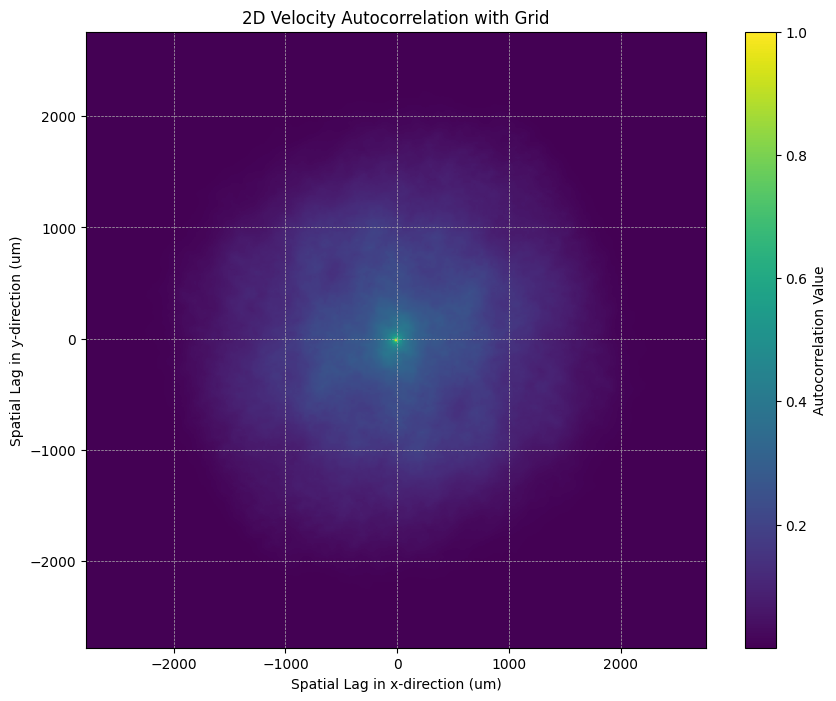

In [8]:
def plot_2D_correlation(data):
    R = compute_velocity_autocorrelation(data)
    
    # Getting the spatial dimensions from the data
    x_values = data['x [um]'].unique()
    y_values = data['y [um]'].unique()
    dx = x_values[1] - x_values[0]
    dy = y_values[1] - y_values[0]
    
    # Extent for the image
    extent = [-R.shape[1]//2*dx, R.shape[1]//2*dx, -R.shape[0]//2*dy, R.shape[0]//2*dy]
    
    plt.figure(figsize=(10, 8))
    plt.imshow(R, cmap='viridis', origin='lower', extent=extent, aspect='auto')
    plt.colorbar(label="Autocorrelation Value")
    plt.title("2D Velocity Autocorrelation with Grid")
    plt.xlabel("Spatial Lag in x-direction (um)")
    plt.ylabel("Spatial Lag in y-direction (um)")
    
    # Displaying the grid
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    plt.show()

plot_2D_correlation(data_0001)


In [13]:
def extract_radial_velocity_autocorrelation(R):
    """
    Extract the radial correlation from the 2D velocity autocorrelation.
    """
    y, x = np.indices(R.shape)

    # Distance from center to any (x,y)
    r = np.sqrt((x - R.shape[1]//2)**2 + (y - R.shape[0]//2)**2).astype(int)
    
    # 
    radial_mean = np.bincount(r.ravel(), R.ravel()) / np.bincount(r.ravel())
    
    return radial_mean

# Extract radial form of the velocity autocorrelation for both frames
radial_velocity_0001 = extract_radial_velocity_autocorrelation(R_velocity_0001)

def exponential_fit(r, A, B, C):
    """
    Exponential function for fitting the autocorrelation.
    """
    return A * np.exp(-r / B) + C

def fit_and_extract_lambda(distances, radial_velocity):
    """
    Fit the radial velocity autocorrelation to the exponential function and extract lambda.
    """
    # Fitting the radial autocorrelation to the exponential function
    popt, _ = curve_fit(exponential_fit, distances, radial_velocity, p0=[1, 100, 0])
    
    # Extracting the correlation length lambda from the fit parameters
    A, B, C = popt
    lambda_val = -B * np.log((0.3 - C) / A)
    
    return lambda_val

# Extracting lambda for the first frame
distances = np.arange(len(radial_velocity_0001))
lambda_0001 = fit_and_extract_lambda(distances, radial_velocity_0001)
lambda_0001


17.77630091375803

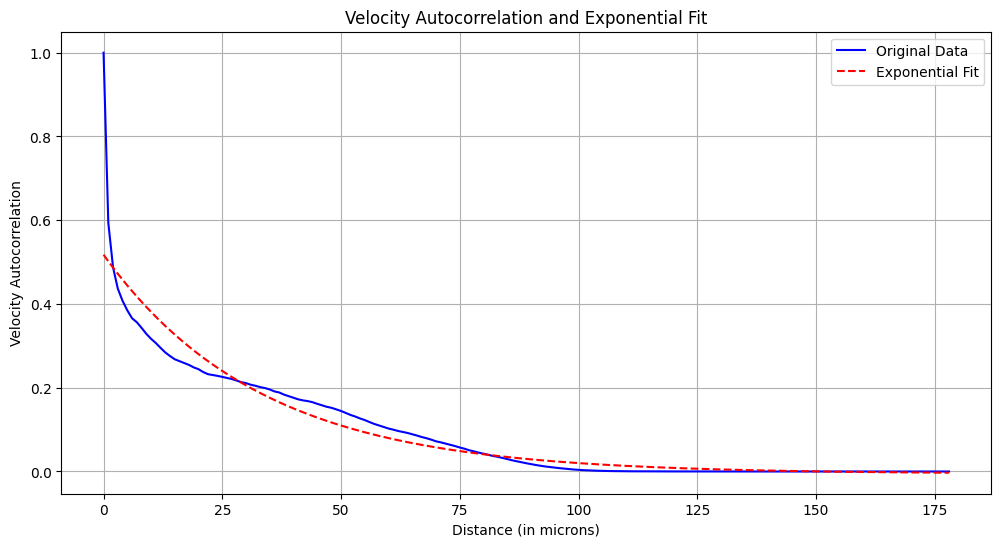

In [14]:
def plot_exponential_fit(distances, radial_velocity):
    """
    Fit the radial velocity autocorrelation to the exponential function and plot the fit along with the original data.
    """
    # Fitting the radial autocorrelation to the exponential function
    popt, _ = curve_fit(exponential_fit, distances, radial_velocity, p0=[1, 100, 0])
    
    # Generating the exponential curve using the fitted parameters
    fitted_curve = exponential_fit(distances, *popt)
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(distances, radial_velocity, 'b-', label="Original Data")
    plt.plot(distances, fitted_curve, 'r--', label="Exponential Fit")
    plt.xlabel("Distance (in microns)")
    plt.ylabel("Velocity Autocorrelation")
    plt.title("Velocity Autocorrelation and Exponential Fit")
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting the exponential fit for the radial_velocity_0001 data
plot_exponential_fit(distances, radial_velocity_0001)


In [21]:
def compute_energy_spectrum(R):
    """
    Compute the energy spectrum from the spatial autocorrelation using the Fourier Transform.
    """
    # Compute the 2D Fourier transform of the autocorrelation function
    F_R = np.fft.fftshift(np.fft.fft2(R))
    
    # Compute the radial energy spectrum (averaging over circular shells in k-space)
    kx = np.fft.fftshift(np.fft.fftfreq(R.shape[0]))
    ky = np.fft.fftshift(np.fft.fftfreq(R.shape[1]))
    kx, ky = np.meshgrid(kx, ky)
    k = np.sqrt(kx**2 + ky**2)
    
    # Define the bins for k (radial wavenumbers)
    k_bins = np.linspace(0, 0.5, R.shape[0]//2)
    k_bin_centers = 0.5 * (k_bins[:-1] + k_bins[1:])
    
    # Compute the binned energy spectrum
    E = np.histogram(k.ravel(), bins=k_bins, weights=(np.abs(F_R)**2).ravel())[0]
    
    return k_bin_centers, E

In [22]:
def exponential_decay(r, L):
    """
    Exponential decay function for fitting.
    """
    return np.exp(-r/L)

def compute_correlation_length(Ru):
    """
    Compute the correlation length by fitting the autocorrelation function to an exponential decay.
    """
    # Extract the 1D radial autocorrelation from the 2D autocorrelation
    y, x = np.indices(Ru.shape)
    r = np.sqrt((x - Ru.shape[1]//2)**2 + (y - Ru.shape[0]//2)**2).astype(np.int64)
    radial_mean = np.bincount(r.ravel(), Ru.ravel()) / np.bincount(r.ravel())
    
    # Fit the radial autocorrelation to the exponential decay function
    r_values = np.arange(len(radial_mean))
    popt, _ = curve_fit(exponential_decay, r_values, radial_mean, p0=[100])
    
    return popt[0]

def extract_radial_velocity_product_correlation(R):
    """
    Extract the radial autocorrelation from the 2D autocorrelation.
    """
    y, x = np.indices(R.shape)
    r = np.sqrt((x - R.shape[1]//2)**2 + (y - R.shape[0]//2)**2).astype(int)
    radial_mean = np.bincount(r.ravel(), R.ravel()) / np.bincount(r.ravel())
    
    return radial_mean



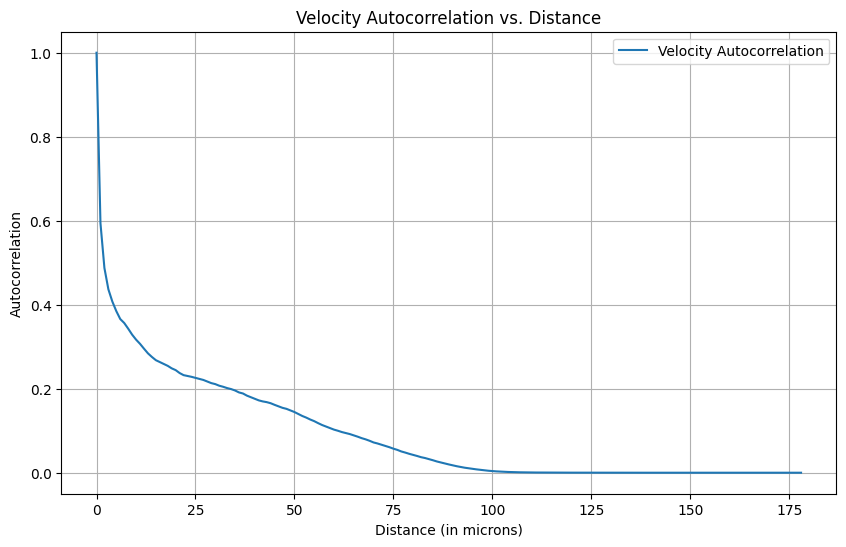

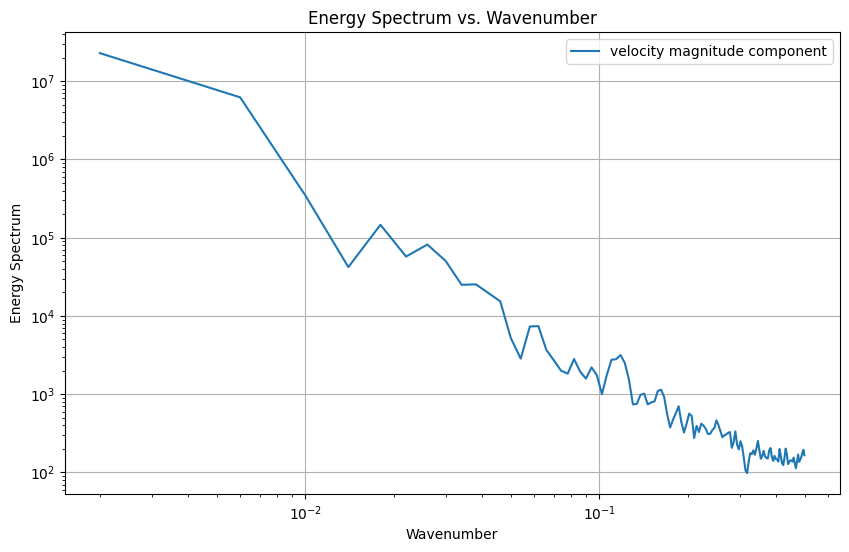

The computed correlation length L is: 12.27 microns


In [25]:
R = compute_velocity_autocorrelation(data_0001)
k, E_avg, = compute_energy_spectrum(R)
L = compute_correlation_length(R)
radial_autocorr = extract_radial_velocity_autocorrelation(R)

# Plotting Velocity Autocorrelation vs. Distance
distances = np.arange(len(radial_autocorr))
plt.figure(figsize=(10,6))
plt.plot(distances, radial_autocorr, label="Velocity Autocorrelation")
plt.xlabel("Distance (in microns)")
plt.ylabel("Autocorrelation")
plt.title("Velocity Autocorrelation vs. Distance")
plt.legend()
plt.grid(True)
plt.show()

# Plotting Energy Spectrum vs. Wavenumber
plt.figure(figsize=(10,6))
plt.loglog(k, E_avg, label="velocity magnitude component")
plt.xlabel("Wavenumber")
plt.ylabel("Energy Spectrum")
plt.title("Energy Spectrum vs. Wavenumber")
plt.legend()
plt.grid(True)
plt.show()

# Displaying the correlation length L
print(f"The computed correlation length L is: {L:.2f} microns")
